# Super-Resolution

**Resnets vs VGG:**

The problem when using resnets as backbone for tasks like *super-resolution* or *segmentation* is that the first 7x7 stride 2 convolution throws away half of the image and therefore most of the fine structure that contains valuable information.

1. VGG has a HUGE fully connected layer at the top which takes lots of memory.
2. Resnets have an adaptive pooling layer at the end that throws away any kind of spatial information (other extreme).

We therefore use VGG today because we want to preserve this fine structure. We actually use a more modern version that incluces batch norm layers.

In [44]:
arch = vgg16
scale = 4
sz_low_res = 72
sz_high_res = sz_low_res * scale

In [2]:
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from pathlib import Path

In [4]:
torch.backends.cudnn.benchmark = True

## Data

In [6]:
PATH = Path('data/imagenet')

In [7]:
TRAIN_PATH = PATH/'train'

In [34]:
filenames, label_arr, labels = folder_source(PATH, 'train')

In [35]:
filenames[:3]

['train/n01440764/n01440764_9649.JPEG',
 'train/n01440764/n01440764_63.JPEG',
 'train/n01440764/n01440764_8063.JPEG']

In [36]:
filenames = ['/'.join(Path(fn).parts[-2:]) for fn in filenames]

`Path('train/n01440764/n01440764_9649.JPEG').parts[-2:]` gives `('n01440764', 'n01440764_9649.JPEG')`

In [37]:
filenames[:3]

['n01440764/n01440764_9649.JPEG',
 'n01440764/n01440764_63.JPEG',
 'n01440764/n01440764_8063.JPEG']

In [38]:
label_arr

array([  0,   0,   0, ..., 773, 773, 773])

In [39]:
labels[:3]

['n01440764', 'n01443537', 'n01491361']

In [40]:
Path('train/n01440764/n01440764_9649.JPEG').parts[-2:]

('n01440764', 'n01440764_9649.JPEG')

### Create a small subset for experimentation

In [41]:
np.random.seed(42)
# keep_perct = 1.
keep_perct = 0.02
keep_indcs = np.random.rand(len(filenames)) < keep_perct
filenames = np.array(filenames, copy=False)[keep_indcs]
label_arr = np.array(label_arr, copy=False)[keep_indcs]

In [79]:
class MatchedFilesDataset(FilesDataset):  # overrides the fastai FilesDataset class
    def __init__(self, fnames, y, transform, path):
        self.y = y
        assert(len(fnames) == len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i):                   # get_y must be overriden so that the label is an image too!
        return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self):
        return 0

In [80]:
augment_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

1. `TfmType.Pixel` makes sure that the label image receives the same transformations as the input image.
1. Dihedral group of order 8: all possible 90 degree rotations + flips. Normally we would not want to use such a transform for a dataset like imagenet because those images are usually not seen upside down. This would make more sense for satellite data etc. Here it does not matter because we are not trying to classifiy but enhance the resolution.

In [81]:
val_indcs = get_cv_idxs(len(filenames), val_pct=min(0.01/keep_perct, 0.1))

In [89]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_indcs, np.array(filenames), np.array(filenames))
# do this with sklearn's train test split function

In [90]:
len(trn_x), len(val_x)

(347, 38)

In [91]:
tfms = tfms_from_model(arch, sz_low_res, tfm_y=TfmType.PIXEL, aug_tfms=augment_tfms, sz_y=sz_high_res)

In [92]:
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_PATH)

In [94]:
bs = 24

In [95]:
modeldata = ImageData(PATH, datasets, bs, num_workers=12, classes=None)

### Let's take a look at a data pair

In [97]:
def show_img(img, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    if normed: img = modeldata.val_ds.denorm(img)
    else: img = to_np(img).transpose(1,2,0)
    ax.imshow(np.clip(img, 0, 1)[idx])
    ax.axis('off')

In [98]:
x, y = next(iter(modeldata.val_dl))

In [99]:
x.size(), y.size()

(torch.Size([24, 3, 72, 72]), torch.Size([24, 3, 288, 288]))

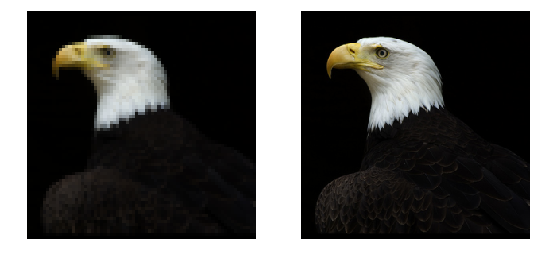

In [103]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(y, idx, ax=axes[1])

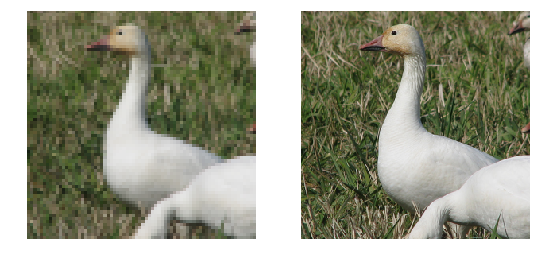

In [104]:
idx = 3
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(y, idx, ax=axes[1])

## Model